# A short Tutorial to process sample NIRISS AMI simulations

* fit fringes for a simulated target and calibrator sequence (no WFE evolution between them)
* calibrate target closure phases with the calibrator
* fit for a binary

In [1]:
import glob
import os, sys, time
from astropy.io import fits
import numpy as np

from nrm_analysis import nrm_core, InstrumentData
#from nrm_analysis.misctools import utils, mask_definitions
#import matplotlib.pyplot as plt
#import cPickle as pickle
#from scipy.special import betainc
#from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline


### Where the data lives:

In [2]:
test_tar = "../tests/example_niriss/t_binary_s198.3_p143.9_cr0.01__nispsf_jit7.0_F480M_15x_ov__00.fits"
test_cal = "../tests/example_niriss/c_binary_s198.3_p143.9_cr0.01__nispsf_jit7.0_F480M_15x_ov__00.fits"


### First we specify the instrument & filter (F480M in this case):

(defaults: Spectral type set to A0V)

In [3]:
niriss = InstrumentData.NIRISS("F480M")

('cvsupport_threshold is: ', {'F430M': 0.02, 'F480M': 0.02, 'F380M': 0.02, 'F277W': 0.02})
{'F430M': 0.02, 'F480M': 0.02, 'F380M': 0.02, 'F277W': 0.02}
================== F480M ===================
('bin by', 30, '  from ', 1007, ' to', 33)
TRIMming
('post trim - spec.shape', (20, 2))
('post specbin - spec.shape', (20, 2))
20 spectral samples between 4.442 and 5.185 um
('filter', 'F480M', 'band.shape', (20, 2), '\n', array([[2.30595912e-04, 4.44200000e-06],
       [1.12156668e-02, 4.56950000e-06],
       [4.07489043e-02, 4.59950000e-06],
       [1.00685445e-01, 4.62950000e-06],
       [3.57056732e-01, 4.65950000e-06],
       [8.57238909e-01, 4.68950000e-06],
       [9.66623765e-01, 4.71950000e-06],
       [9.15453765e-01, 4.74950000e-06],
       [9.35188058e-01, 4.77950000e-06],
       [9.91308648e-01, 4.80950000e-06],
       [9.79337483e-01, 4.83950000e-06],
       [9.27134702e-01, 4.86950000e-06],
       [9.32951022e-01, 4.89950000e-06],
       [9.29345466e-01, 4.92950000e-06],
      

### Next: get fringe observables via image plane fringe-fitting
* Need to pass the InstrumentData object, some keywords.
* Files will be saved into specified directory + new directory named by filename


In [4]:
ff_t = nrm_core.FringeFitter(niriss, savedir="targ/", oversample=5, interactive=False) 
ff_c = nrm_core.FringeFitter(niriss, savedir="cal/", oversample=5, interactive=False) 
#in general set interactive to False unless you really don't know what you are doing
                                                        

In [5]:
# This can take a little while -- there is a parallelization option, set threads=n_threads
ff_t.fit_fringes(test_tar)
ff_c.fit_fringes(test_cal)

[[-0.        -2.64     ]
 [ 2.28631    0.       ]
 [-2.28631   -1.3200001]
 [ 2.28631    1.3200001]
 [ 1.14315    1.98     ]
 [-2.28631    1.3200001]
 [-1.14315    1.98     ]]
('Before cropping:', (81, 81))
('peaking on: ', 9018889.14742086)
('peak x,y:', 41, 41)
('Cropped image shape:', (77, 77))
('value at center:', 9018889.14742086)
(array([38]), array([38]))
>>> utils.find_centroid(): M.shape (77, 77), a.shape (77, 77)
(array([12, 12, 12, ..., 64, 64, 64]), array([31, 32, 33, ..., 43, 44, 45]))
>>> utils.find_centroid(): M.shape (77, 77), cvpha.shape (77, 77)
>>>> nrm_core: centroid offsets (-0.39026923690553944, -0.4617441941885966) from utils.centroid() <<<<
>>>> nrm_core: center of light in array coords (ds9) [37.53825581 37.60973076] <<<<
>>>> nrm_core.fit_image(): refslice 6 lines commented out cf LG+ <<<<

**** nrm.core.fit_fringes_single_integration: will try to find best center for image in data
**** nrm.core.fit_fringes_single_integration: because 'hold_centering' is False

You'll find some new files. Text files save the observables you are trying to measure, but there are also some diagnostic fits files written: centered_X are the cropped/centered data, modelsolution_XX are the best fit model to the data, and residual_XX is the difference between the two. 

Coming soon: propogating errors from fringe-fitting to observables.

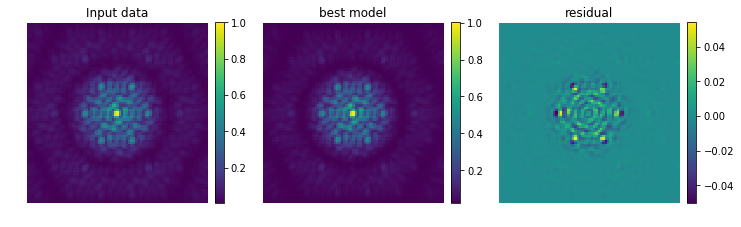

In [6]:
data = fits.getdata("targ/t_binary_s198.3_p143.9_cr0.01__nispsf_jit7.0_F480M_15x_ov__00/centered_5.fits")
fmodel = fits.getdata("targ/t_binary_s198.3_p143.9_cr0.01__nispsf_jit7.0_F480M_15x_ov__00/modelsolution_05.fits")
res = fits.getdata("targ/t_binary_s198.3_p143.9_cr0.01__nispsf_jit7.0_F480M_15x_ov__00/residual_05.fits")

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("Input data")
im = plt.imshow(pow(data/data.max(), 0.5))
plt.axis("off")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.title("best model")
im = plt.imshow(pow(fmodel/data.max(), 0.5))
plt.axis("off")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.title("residual")
im = plt.imshow(res/data.max())
plt.axis("off")
plt.colorbar(fraction=0.046, pad=0.04)


If you don't want to clog up your hardrive with fits files you can initialize FringeFitter with keyword "save_txt_only=True" -- but you may want to save out everything the first time you reduce the data to check it. Above we can see a pretty good fit the magnification of the model is a bit off. This shows up as a radial patter in the residual. Finely fitting the exact magnification and rotation should be done before fringe fitting. 

### Calibration is simple: point to the data

The most important thing is to pass the right InstrumentData object with correct parameters so wavelength, pixelscale, etc. can be interpreted into on-sky spatial frequency. This can write out an oifits file.

In [5]:
tdir = "targ/t_binary_s198.3_p143.9_cr0.01__nispsf_jit7.0_F480M_15x_ov__00/"
cdir = "cal/c_binary_s198.3_p143.9_cr0.01__nispsf_jit7.0_F480M_15x_ov__00/"
calib = nrm_core.Calibrate([tdir, cdir], niriss, savedir = "calibrated_example/", interactive=False)

exposures flagged: []
exposures flagged: []


/Users/azgreenb/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [6]:
calib.save_to_oifits("exampleoifitsfiles.oifits") # will save into specified "savedir"
# Saved to oifits files are average fringe phasses, closure phases, visibility amplitudes,  
# closure amplitudes & errors over the sequence of observations, wavelength and baseline info

{}
no mask rotation
Opening calibrated_example//exampleoifitsfiles.oifits


/Users/azgreenb/pythonmodules/oifits.py:868: PyfitsDeprecationWarning: The new_table function is deprecated as of version 3.3 and may be removed in a future version.

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
  pyfits.Column(name='EFF_BAND', format='1E', unit='METERS', array=wavelength.eff_band)
/Users/azgreenb/pythonmodules/oifits.py:932: PyfitsDeprecationWarning: The new_table function is deprecated as of version 3.3 and may be removed in a future version.

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.
  pyfits.Column(name='SPECTYP', format='A16', array=spectyp)
/Users/azgreenb/pythonmodules/oifits.py:960: PyfitsDeprecationWarning: The new_table function is deprecated as of version 3.3 and may be removed in a future version.

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from

1 wavelength table with 1 wavelength in total
1 target
1 array with 1 station
21 visibility^2 measurements
35 closure phase measurements


### Now what to do with an oifits file? Example: fit a binary

In [4]:
# BinaryAnalyze module in nrm_core is a convenient way to load in your oifits file
ba = nrm_core.BinaryAnalyze("calibrated_example/exampleoifitsfiles.oifits", savedir="calibrated_example/")

Opening calibrated_example/exampleoifitsfiles.oifits
1 wavelength table with 1 wavelength in total
1 target
1 array with 1 station
21 visibility^2 measurements
35 closure phase measurements
oifits has no parang info, moving on...


/Users/azgreenb/pythonmodules/nrm_analysis/nrm_analysis/nrm_core.py:2120: RuntimeWarning: Mean of empty slice.
  self.phaerr[self.phaerr<floor] = self.phaerr[self.phaerr!=0.0].mean()
/Users/azgreenb/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


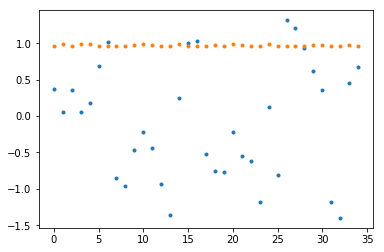

In [9]:
# Want to see what your closure phases look like?
plt.plot(ba.cp, '.')
# Bispectrum amplitudes:
plt.plot(ba.t3amp, '.')

In [11]:
# Can do a coarse fit for binary parameters. 
# The binary in this case has a contrast of 0.01 at about 200mas, 
# so it should be pretty easy to recover.
coarse_params = ba.chi2map(nstep=45, maxsep=400, clims=[1e-4, 0.9])

took 0.0026969909668s to assemble position grids
(2, 3, 35, 45, 45, 1)
(35, 1)
(45, 45, 1)
(1,)
Threads: 4
took 0.711658000946s to compute all chi^2 grid points
Best Contrast: [0.00948683]
Best Separation: [207.30462275]
Best PA: [37.87498365]


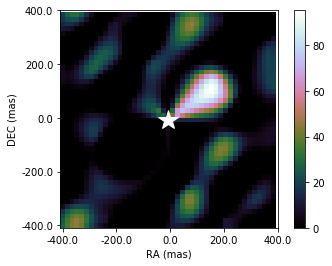

In [13]:
plt.figure()
plt.plot(45/2.0 -0.5,45/2.0 - 0.5, marker="*", color='w', markersize=20)
plt.imshow(np.sqrt(ba.significance), cmap="cubehelix", interpolation="nearest")
plt.xlabel("RA (mas)")
plt.ylabel("DEC (mas)")
plt.xticks(np.linspace(0, 45, 5), np.linspace(ba.ras.min(), ba.ras.max(), 4+1))
plt.yticks(np.linspace(0, 45, 5), np.linspace(ba.decs.min(), ba.decs.max(), 4+1))
plt.gca().invert_yaxis()
plt.colorbar()

## We can now do a finer fit with this coarse search as a starting point

For a finer fit you can use the run_emcee method, or if you want more control you can define your own likelihood function

priors:
[(1e-05, 0.99), (20.0, 400.0), (-180.0, 180.0)]
keys ['con', 'sep', 'pa']
params [9.48683298e-03 2.07304623e+02 3.78749837e+01]
[9.48683298e-03 2.07304623e+02 3.78749837e+01]
p0 100
burn in complete, took  2.05300712585 s
Mean acceptance fraction: 0.651
This number should be between ~ 0.25 and 0.5 if everything went as planned.
ran mcmc, took 19.6048099995 s
emcee found....
con : 0.009728190394042031 +/- 2.905524616497377e-05
sep : 201.04752545747482 +/- 0.23853273694780122 mas
pa : 36.24834164427998 +/- 0.0520298323845917 deg


<Figure size 432x288 with 0 Axes>

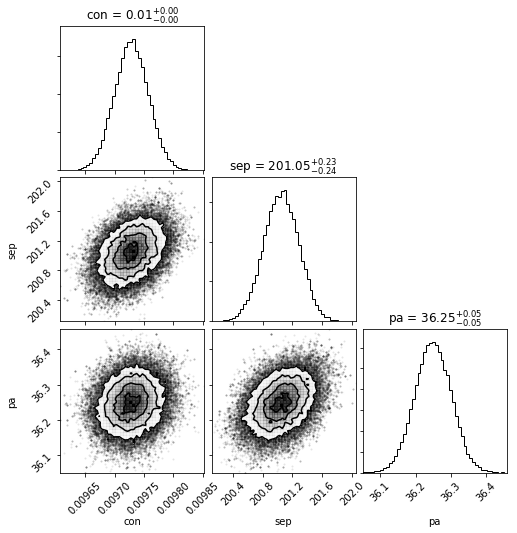

<Figure size 432x288 with 0 Axes>

In [17]:
con, sep, pa = np.array(coarse_params)
if pa > 180.0:
    pa = 360-pa
guess = {"con":con, "sep":sep, "pa":pa}
priors = [(1e-5, 0.99), (20.0, 400.0), (-180.0,180.0)]
ba.run_emcee(guess, nwalkers=100, niter=1000, priors=priors, \
                     threads=4, burnin = 100, \
                     # scale is to account for rendundancy in closure phase baselines
                     scale = np.sqrt(7/3.0))
# set so it will show in the notebook in addition to being written out
ba.plot="on"
ba.corner_plot("test_mcmc.pdf")

In [24]:
from nrm_analysis.modeling.binarymodel import model_cp_uv, model_t3amp_uv

def logl(data, err, model):
    """
    Likelihood given data, errors, and the model values
    These are all shape (nobservable, nwav)
    """
    #err*=np.sqrt(10.0/3.0)
    chi2 = np.sum(((data-model)/err)**2)
    loglike = -chi2/2.0
    return loglike

def cp_binary_model(params, binset, priors):
    """
    len(params) must be len(nrank) +2 (for sep, pa)
    """
    for i in range(len(params)):
        if (params[i] < priors[i][0] or params[i] > priors[i][1]):  
            return -np.inf

    contrasts = params[2:]
    seps = params[0]
    pas = params[1]

    model_cp = model_cp_uv(binset.uvcoords, contrasts, seps, pas, 1.0/binset.wavls)
    ll = logl(binset.cp, binset.cperr , model_cp)
    return ll

def all_binary_model(params, binset, priors):
    
    for i in range(len(params)):
        if (params[i] < priors[i][0] or params[i] > priors[i][1]):  
            return -np.inf

    contrasts = params[2:]
    seps = params[0]
    pas = params[1]

    model_cp = model_cp_uv(binset.uvcoords, contrasts, seps, pas, 1.0/binset.wavls)
    model_t3 = model_t3amp_uv(binset.uvcoords, contrasts, seps, pas, 1.0/binset.wavls)
    model_all = np.concatenate((model_cp, model_t3))
    obs_all = np.concatenate((binset.cp, binset.t3amp))
    obserr_all = np.concatenate((binset.cperr, binset.t3amperr))
    ll = logl(obs_all, obserr_all , model_all)
    return ll


In [29]:
import emcee
con, sep, pa = np.array(coarse_params)
if pa>180.0:
    pa = 360 - pa
params = np.array([sep, pa, con])
nwalkers = 100
niter = 1000
p0 = [params + 0.1*params*np.random.rand(len(params)) for i in range(nwalkers)]
priors = [ (0.0, 300.0), (-180.0, 180.0), (1e-4, .99)]
sampler = emcee.EnsembleSampler(nwalkers, len(params), cp_binary_model,
                                threads=1, args=[ba, priors])
t0 = time.time()
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
t1 = time.time()
print "burn in complete, took ", t1-t0, "s"
pos, prob, state = sampler.run_mcmc(pos, niter)
t2 = time.time()
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print "This number should be between ~ 0.25 and 0.5 if everything went as planned."
print "ran mcmc, took", t2 - t1, "s"
chain = sampler.flatchain
fullchain = sampler.chain


burn in complete, took  1.3889670372 s
Mean acceptance fraction: 0.647
This number should be between ~ 0.25 and 0.5 if everything went as planned.
ran mcmc, took 13.7111399174 s


Recovered:
---------
(0.00972788385649663, '+/-', 4.4389980208454916e-05, 4.596073113235892e-05)
(201.0494375303649, '+/-', 0.3640624407157418, 0.36064319019214963)
(36.249306308770116, '+/-', 0.07817241776197648, 0.07907437609694057)


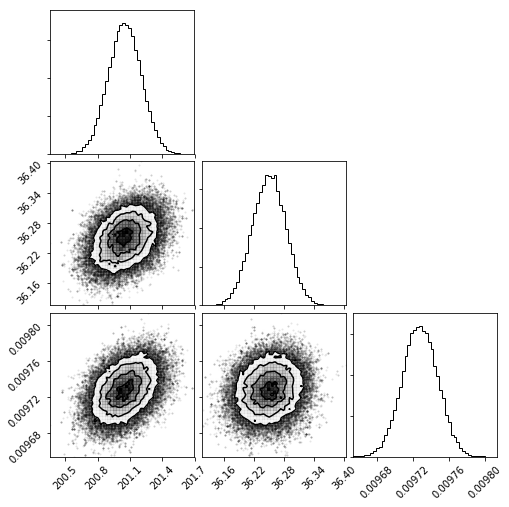

In [35]:
import corner

samples = sampler.chain[:, 50:, :].reshape((-1, len(params)))
pq = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
         zip(*np.percentile(samples, [1, 50, 99],axis=0)))
print("================")
print("Recovered:")
print("---------")
print(pq[2][0],"+/-",pq[2][1],pq[2][2])
print(pq[0][0],"+/-",pq[0][1],pq[0][2])
print(pq[1][0],"+/-",pq[1][1],pq[1][2])
print("================")

fig = corner.corner(chain, bins = 50)